In [1]:
import geopandas as gpd
import datetime
import json
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tx_fast_hydrology.muskingum import Muskingum, ModelCollection, Connection
from tx_fast_hydrology.simulation import AsyncSimulation

In [2]:
shoal_waller = gpd.read_file('../data/ESRI_streamlines_trimmed/Splitline_Trimmed.shp')
shoal_waller = shoal_waller.to_crs("EPSG:4326")
shoal_waller # SplitID is not unique but GridID [or HydroID] is 

,arcid,GridID,Shape_Leng,OrigLength,SplitID,HydroID,From_Node,To_Node,NextDownID,PU_Order,DrainID,LengthKM,geometry
0,1,3578,539.037192,539.037192,3520,3578,1,2,3579,1,3790,0.164299,"LINESTRING (-97.73889 30.38132, -97.73888 30.3..."
1,3,3579,908.957019,908.957019,3522,3579,2,3,3602,4,3791,0.277051,"LINESTRING (-97.73745 30.38117, -97.73743 30.3..."
2,7,3580,1734.160458,1734.160458,3526,3580,4,5,3613,7,3792,0.528573,"LINESTRING (-97.73718 30.3696, -97.73718 30.36..."
3,13,3581,1415.009603,1415.009603,3532,3581,6,7,3621,10,3793,0.431296,"LINESTRING (-97.73951 30.35787, -97.73951 30.3..."
4,29,3582,2097.934781,2097.934781,3548,3582,8,9,3665,1,3794,0.639452,"LINESTRING (-97.72943 30.30189, -97.72943 30.3..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,53,3702,1805.680165,3611.360330,3572,3702,127,23,3593,31,3914,0.550372,"LINESTRING (-97.75089 30.26456, -97.75089 30.2..."
124,54,3704,2398.477662,4796.955323,3573,3704,129,23,3593,2,3916,0.731057,"LINESTRING (-97.75244 30.26446, -97.75243 30.2..."
125,56,3705,1867.017504,3734.035007,3575,3705,22,130,3706,23,3917,0.569068,"LINESTRING (-97.73688 30.26378, -97.73688 30.2..."
126,56,3706,1867.017504,3734.035007,3575,3706,130,24,3711,24,3918,0.569068,"LINESTRING (-97.74017 30.26149, -97.74017 30.2..."


In [3]:
assert (shoal_waller['GridID'] == shoal_waller['HydroID']).all()

In [4]:
shoal_waller['reach_ids'] = shoal_waller['HydroID'].astype('str')
shoal_waller['dx'] = shoal_waller['LengthKM']*1000
shoal_waller['K'] = shoal_waller['dx'] / 2.12
shoal_waller['X'] = [0.25 for i in range(shoal_waller['reach_ids'].size)]
shoal_waller['o_t'] = [0 for i in range(shoal_waller['reach_ids'].size)]
shoal_waller ['startnodes'] = [i for i in range(shoal_waller['reach_ids'].size)]

In [5]:
shoal_waller

,arcid,GridID,Shape_Leng,OrigLength,SplitID,HydroID,From_Node,To_Node,NextDownID,PU_Order,DrainID,LengthKM,geometry,reach_ids,dx,K,X,o_t,startnodes
0,1,3578,539.037192,539.037192,3520,3578,1,2,3579,1,3790,0.164299,"LINESTRING (-97.73889 30.38132, -97.73888 30.3...",3578,164.298865,77.499464,0.25,0,0
1,3,3579,908.957019,908.957019,3522,3579,2,3,3602,4,3791,0.277051,"LINESTRING (-97.73745 30.38117, -97.73743 30.3...",3579,277.050654,130.684271,0.25,0,1
2,7,3580,1734.160458,1734.160458,3526,3580,4,5,3613,7,3792,0.528573,"LINESTRING (-97.73718 30.3696, -97.73718 30.36...",3580,528.573165,249.326964,0.25,0,2
3,13,3581,1415.009603,1415.009603,3532,3581,6,7,3621,10,3793,0.431296,"LINESTRING (-97.73951 30.35787, -97.73951 30.3...",3581,431.295790,203.441410,0.25,0,3
4,29,3582,2097.934781,2097.934781,3548,3582,8,9,3665,1,3794,0.639452,"LINESTRING (-97.72943 30.30189, -97.72943 30.3...",3582,639.451800,301.628208,0.25,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,53,3702,1805.680165,3611.360330,3572,3702,127,23,3593,31,3914,0.550372,"LINESTRING (-97.75089 30.26456, -97.75089 30.2...",3702,550.372415,259.609630,0.25,0,123
124,54,3704,2398.477662,4796.955323,3573,3704,129,23,3593,2,3916,0.731057,"LINESTRING (-97.75244 30.26446, -97.75243 30.2...",3704,731.057453,344.838421,0.25,0,124
125,56,3705,1867.017504,3734.035007,3575,3705,22,130,3706,23,3917,0.569068,"LINESTRING (-97.73688 30.26378, -97.73688 30.2...",3705,569.068073,268.428336,0.25,0,125
126,56,3706,1867.017504,3734.035007,3575,3706,130,24,3711,24,3918,0.569068,"LINESTRING (-97.74017 30.26149, -97.74017 30.2...",3706,569.068073,268.428336,0.25,0,126


In [6]:
endnodes = []
for i,v in enumerate(shoal_waller['NextDownID'].values):
    if v in shoal_waller['HydroID'].values:
        index = shoal_waller[shoal_waller['HydroID']== v].index[0]
        endnodes.append(shoal_waller ['startnodes'][index].item())
    else:
        endnodes.append(shoal_waller ['startnodes'][i].item())

In [7]:
shoal_waller ['endnodes'] = endnodes

In [8]:
shoal_waller.columns

Index(['arcid', 'GridID', 'Shape_Leng', 'OrigLength', 'SplitID', 'HydroID',
       'From_Node', 'To_Node', 'NextDownID', 'PU_Order', 'DrainID', 'LengthKM',
       'geometry', 'reach_ids', 'dx', 'K', 'X', 'o_t', 'startnodes',
       'endnodes'],
      dtype='object')

In [9]:
shoal_waller[['HydroID','NextDownID', 'startnodes', 'endnodes']].head(10)

,HydroID,NextDownID,startnodes,endnodes
0,3578,3579,0,1
1,3579,3602,1,24
2,3580,3613,2,35
3,3581,3621,3,43
4,3582,3665,4,87
5,3583,3673,5,95
6,3584,3677,6,99
7,3585,3677,7,99
8,3586,3589,8,11
9,3587,3589,9,11


In [10]:
print(shoal_waller.crs)
shoal_waller['geometry']

EPSG:4326


0      LINESTRING (-97.73889 30.38132, -97.73888 30.3...
1      LINESTRING (-97.73745 30.38117, -97.73743 30.3...
2      LINESTRING (-97.73718 30.3696, -97.73718 30.36...
3      LINESTRING (-97.73951 30.35787, -97.73951 30.3...
4      LINESTRING (-97.72943 30.30189, -97.72943 30.3...
                             ...                        
123    LINESTRING (-97.75089 30.26456, -97.75089 30.2...
124    LINESTRING (-97.75244 30.26446, -97.75243 30.2...
125    LINESTRING (-97.73688 30.26378, -97.73688 30.2...
126    LINESTRING (-97.74017 30.26149, -97.74017 30.2...
127    LINESTRING (-97.74199 30.25771, -97.74198 30.2...
Name: geometry, Length: 128, dtype: geometry

In [11]:
paths = []

for line in shoal_waller['geometry']:
    coords = list(line.coords)  # Extract list of (x, y) tuples
    path = [[x, y] for x, y in coords]  # Convert to nested list
    paths.append([path])  # Match the structure: paths[i][0][j] = [x, y]

# Now wrap in a dict if you want to export to JSON
paths_json = {"paths": paths}


In [15]:
shoal_waller_dict = {
    'reach_ids': shoal_waller['reach_ids'].to_list(),
    'startnodes': shoal_waller['startnodes'].to_list(),
    'endnodes': shoal_waller ['endnodes'].to_list(),
    'K': shoal_waller['K'].to_list(),
    'X': shoal_waller['X'].to_list(),
    'o_t': shoal_waller['o_t'].to_list(),
    'dx': shoal_waller['dx'].to_list(),
    'paths': paths,
}


In [16]:
shoal_waller_dict['datetime'] = '2024-12-31T23:58:00+00:00'
shoal_waller_dict['timedelta'] = 'P0DT0H2M0S'
shoal_waller_dict['name'] = "SHL_WAL"
shoal_waller_dict = {'model': shoal_waller_dict}
shoal_waller_dict['sinks'] = []
shoal_waller_dict['sources'] = []
shoal_waller_dict = {"SHL_WAL": shoal_waller_dict}
shoal_waller_dict = {'models': shoal_waller_dict}
shoal_waller_dict['connections'] = {}
shoal_waller_dict.keys()

dict_keys(['models', 'connections'])

In [17]:
with open('../data/shoal_waller_less_densified.json', 'w') as f:
    json.dump(shoal_waller_dict, f, indent=2)

In [18]:
# Define model file input path
input_path = '../data/shoal_waller_less_densified.json'
# Load model collection from file
model_collection = ModelCollection.from_file(input_path)

Text(0.5, 1.0, 'Shoal and Waller')

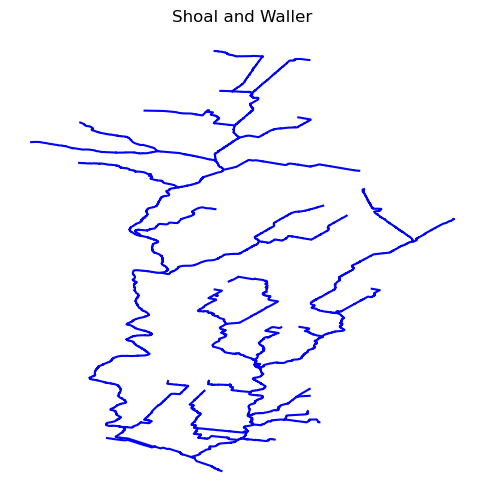

In [20]:
# Shoal creek and waller creek
fig, ax = plt.subplots(figsize=(6,6))
for model_name, model in model_collection.models.items():
    model.plot(ax=ax, c='b')
plt.axis('off')
plt.title('Shoal and Waller')